In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
from vips import vipp
from calc_metrics import calc_metrics
import random
from collections import Counter
from tqdm import tqdm

In [2]:
#new_raw_counts = pd.read_csv('../data/BAL/Reseq_ALL/counts_reseq.csv', sep='\t', 
#                     index_col='sample_id')
meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')
new_fpkm = pd.read_csv("../data/BAL/new_counts_fpkm_R.txt",sep='\t')#, index_col='sample_id')

old_fpkm = pd.read_csv('../data/BAL/Run0/granges.fpkms.txt', sep='\t').T
old_meta = pd.read_csv('../data/BAL/meta_r0.csv', sep='\t', index_col=0)

In [3]:
new_fpkm = new_fpkm.T

### Require X % of samples to have Y gene greater than 0

In [4]:
## Enforce minimum percentage of samples that have > min_count
def check_min_percent(df, min_percent, min_count=0):
    new_cols = []
    for gene in df.columns:
        percent_above_zero = float(len([x for x in df[gene].values if x > min_count]))/len(df[gene].values)*100
        if percent_above_zero >= min_percent:
            new_cols.append(gene)
    return df[new_cols]

In [5]:
new_fpkm.shape

(95, 57785)

In [5]:
new_fpkm = new_fpkm.apply(lambda x: np.log2(x + 1))
new_fpkm = check_min_percent(new_fpkm, min_percent=75)

In [60]:
new_fpkm.shape

(95, 4936)

In [6]:
old_fpkm = old_fpkm.apply(lambda x: np.log2(x + 1))
old_fpkm = check_min_percent(old_fpkm, min_percent=75)

In [7]:
new_fpkm = new_fpkm[[col for col in new_fpkm.columns if col in old_fpkm.columns]]

In [8]:
new_fpkm.shape, old_fpkm.shape

((95, 4936), (32, 16746))

## Raw counts to FPKM 

In [15]:
print old_fpkm.shape, old_meta.shape
print new_fpkm.shape, meta.shape

(32, 16746) (32, 2)
(95, 5175) (95, 32)


### In this study we have significantly more negative than positive samples
### The function geteven_xy() returns an even number of neg and pos
   - sampling = 'up' means that a random number of pos samples are added to make up the difference (there are duplicate pos. samples)
   - sampling = 'down' means that a random number of neg. samples are removed (there are no duplicates, but the total number of samples is far fewer than when upsampling). 

In [9]:
def geteven_xy(df, dfm, celltype, sampling='up', norm=False, even=True):
    dfm = dfm[dfm['CellType']==celltype]
    y = dfm['Pneum'].values
    df = df.ix[dfm.index]
    #    if z: df = df.apply(lambda x: zscore(x))
    genes = df.columns
    pos = [i for i in range(len(y)) if y[i]==True]
    neg = [i for i in range(len(y)) if y[i]==False]
    
    npos = len(pos)
    nneg = len(neg)

    #    print "Num positive: {}".format(len(pos))
    #    print "Num negative: {}".format(len(neg))
    if even:
        if sampling=='down':
            if nneg >= npos:
                neg = random.sample(neg, npos)
            else:
                pos = random.sample(pos, nneg)
        if sampling=='up':
            if nneg >= npos:
                dup_pos = random.sample(pos+pos, nneg-npos)
                pos = pos + dup_pos ## pos+pos in case not enough in pos
        #            print "duplicated pos:", dup_pos
            else:
                neg = neg + random.sample(neg+neg, npos-nneg)

    df = df.ix[(pos+neg),:]
    """
    Normalize from zero to one
    5, 8, 10
    5 - 5 / (10-5)
    8 - 5 / (10-5)
    10 - 5 / (10-5)
    """
    
    if norm=='zero_one': 
        for col in df.columns:
            mx = np.max(df[col])
            mn = np.min(df[col])
            df[col] = df[col].map(lambda x: (x - mn)/(mx - mn))
            
    if norm=='zsc': 
        df = df.apply(lambda x: zscore(x))
    #elif norm==zero_one:
    #    df = df.apply(lambda x: )
    dfm = dfm.ix[(pos+neg),:]
    X = np.array(df)
    y = dfm['Pneum'].values
    #print "Num pos after sampling: {}".format(len(pos))
    #print "Num neg after sampling: {}".format(len(neg))
    #y = y[pos + neg] 
    #X = X[pos + neg] 
    return X,y, genes, df, dfm

In [ ]:

def get_accuracy_stats(n, sampling, celltype, 
                   n_top_genes, norm=False,
                  flip_test_y=False, flip_train_y=False, train_even=True, test_even=False):
    
    neg_accuracy_train = []
    neg_accuracy_test = []
    pos_accuracy_train = []
    pos_accuracy_test = []
    all_top_genes_train = []
    top_top_genes_train = [] # not a typo - these are the top across random samplings (n) of the top genes from LOO
    old_genes = old_fpkm.columns
    
    ### TRAINING
    #################
    
    ## Get most common genes from each model
    for i in tqdm(range(n), desc="Training"):
        X, y, genes, df, dfm = geteven_xy(new_fpkm, meta, celltype=celltype, sampling=sampling, norm=norm, even=train_even)
        #print y
        if flip_train_y:
            y = np.array(map(lambda x: True if x==0 else False, y))
        #    print y
        neg_err, pos_err, Q2, pos_corr, neg_corr, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
        all_vips = [g for m in vip_inds for g in m]
        c = Counter(all_vips)
        top_inds = [i[0] for i in c.most_common(n_top_genes)]
        top_genes_train = [genes[i] for i in top_inds]
        all_top_genes_train += top_genes_train
        
        neg_accuracy_train.append(neg_corr)
        pos_accuracy_train.append(pos_corr)

    
    ### Get the best of the top genes across all X,y
    c = Counter(all_top_genes_train)
    top_top_genes_train = [i[0] for i in c.most_common(n_top_genes)]
    
    ### Build model based on those genes
    pls = PLSRegression(5, scale=True)
    X = np.array(df[top_top_genes_train])
    y = np.array(dfm['Pneum'])
    pls.fit(X, y)
        
    
    ### TESTING
    ###############
    
    ### Random up-samples of old data for predictions
    if test_even==False:
        n = 1
        
    for i in tqdm(range(n), desc="Testing"):
        X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(old_fpkm, 
                            old_meta, celltype=celltype, sampling=sampling, norm=norm, even=test_even)
        #print y_test
        if flip_test_y:
            y_test = np.array(map(lambda x: True if x==0 else False, y_test))
        X_test = np.array(df_test[top_top_genes_train])

        y_pred = pls.predict(X_test)
        #for i in range(len(y_pred)):
        #    print y_test[i] - y_pred[i]
        
        neg_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==0]
        #print "Negative error: ", neg_err
        neg_acc = float(sum([(e < 0.5) for e in neg_err])) / len(neg_err)
        #print "Negative acc: ", neg_acc
        
        pos_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==1]
        print "Positive error: ", pos_err
        pos_acc = float(sum([(e < 0.5) for e in pos_err])) / len(pos_err)
        #print "Positive acc: ", pos_acc

        neg_accuracy_test.append(neg_acc)
        pos_accuracy_test.append(pos_acc)
        
    #print "positive error mean= {}".format(np.mean(pos_err))
    #print "negative error mean= {}".format(np.mean(neg_err))
    return neg_accuracy_train, neg_accuracy_test, pos_accuracy_train, pos_accuracy_test

# Uneven only

In [25]:
testAM_uneven = get_accuracy_stats(n=1, celltype='AM', 
                        n_top_genes=100, sampling='up', 
                        norm='zsc', flip_test_y=False, flip_train_y=False, train_even=False, test_even=False)



Training: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

Positive error:  [0.06024259003353727, 0.7307889833997827, 0.6018853869183209, 0.36772097143396154, 0.8402164847985742, 0.5693915556837843]


In [26]:
test163_uneven = get_accuracy_stats(n=1, celltype='CD163', 
                        n_top_genes=100, sampling='up', 
                        norm='zsc', flip_test_y=False, flip_train_y=False, train_even=False, test_even=False)



Training: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

Positive error:  [0.7692910665507061, 0.5143676285054924, 0.1715414681427916, 1.037733377426228, 1.0073048213560754, 1.0432904113950523, 0.07614887264573289]


In [28]:
testAM_uneven

([0.21052631578947367], [0.7857142857142857], [0.6], [0.3333333333333333])

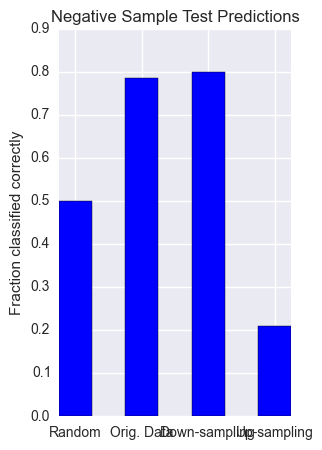

In [27]:
index = np.arange(4)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, testAM_uneven[1][0], test163_uneven[1][0], testAM_uneven[0][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'Orig. Data', 'Down-sampling', 'Up-sampling'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Test Predictions")

# Up / Down / Uneven

In [21]:
testAM_up = get_accuracy_stats(n=10, celltype='AM', 
                        n_top_genes=100, sampling='up', 
                        norm='zsc', flip_test_y=False, flip_train_y=False, train_even=True, test_even=False)



Training: 100%|██████████| 10/10 [00:48<00:00,  4.91s/it]

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

Positive error:  [0.10663355488801074, 0.7324262998164539, 0.5729073043020005, 0.3639409830012078, 0.7788490363038403, 0.2695271664861464]


In [22]:
testAM_dn = get_accuracy_stats(n=10, celltype='AM', 
                        n_top_genes=100, sampling='down', 
                        norm='zsc', flip_test_y=False, flip_train_y=False, train_even=True, test_even=False)



Training: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

Positive error:  [0.23514580982113498, 0.9359173863348738, 0.7323358427080158, 0.506637639761261, 0.5408406415626301, 0.27495781702036415]


In [23]:
testAM_uneven = get_accuracy_stats(n=10, celltype='AM', 
                        n_top_genes=100, sampling='down', 
                        norm='zsc', flip_test_y=False, flip_train_y=False, train_even=False, test_even=False)



Training: 100%|██████████| 10/10 [00:42<00:00,  4.27s/it]

Testing: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

Positive error:  [0.06024259003353727, 0.7307889833997827, 0.6018853869183209, 0.36772097143396154, 0.8402164847985742, 0.5693915556837843]


In [16]:
#test163_uneven# = test163_up

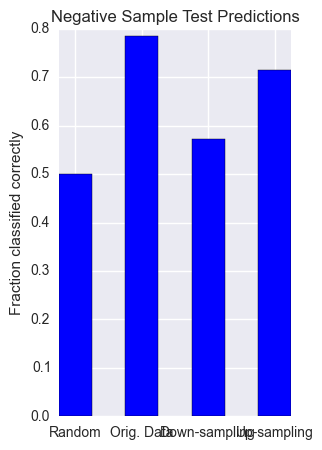

In [24]:
index = np.arange(4)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, testAM_uneven[1][0], testAM_dn[1][0], testAM_up[1][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'Orig. Data', 'Down-sampling', 'Up-sampling'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Test Predictions")

In [32]:
testAM_uneven[1]

[0.7857142857142857]

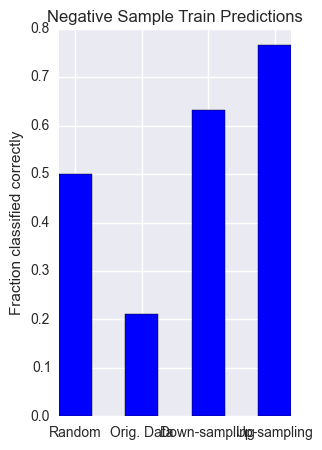

In [33]:
index = np.arange(4)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, testAM_uneven[0][0], testAM_dn[0][0], testAM_up[0][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'Orig. Data', 'Down-sampling', 'Up-sampling'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Train Predictions")

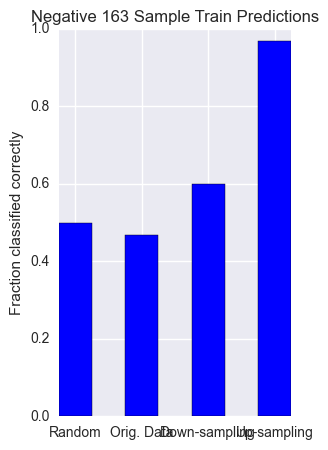

In [34]:
index = np.arange(4)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, test163_uneven[0][0], test163_dn[0][0], test163_up[0][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'Orig. Data', 'Down-sampling', 'Up-sampling'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative 163 Sample Train Predictions")

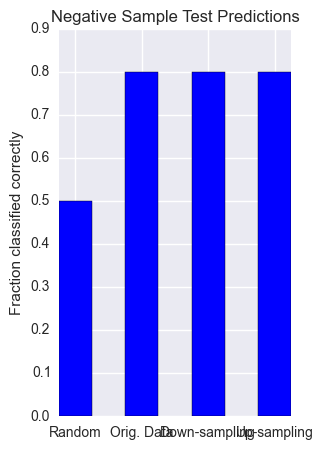

In [19]:
index = np.arange(4)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, test163_uneven[1][0], test163_dn[1][0], test163_up[1][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'Orig. Data', 'Down-sampling', 'Up-sampling'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Test Predictions")

In [ ]:
index = np.arange(3)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, testAM_100[1][0], test163_100[1][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'AM model', 'CD163+ model'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Test Predictions")

## AM - top 20 genes - 
### downsampling

In [ ]:
test163_up = get_accuracy_stats(n=10, celltype='CD163', 
                        n_top_genes=100, sampling='up', 
                        norm='zsc', flip_test_y=False, flip_train_y=False, train_even=True, test_even=False)


Testing: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]

### FINAL FIG

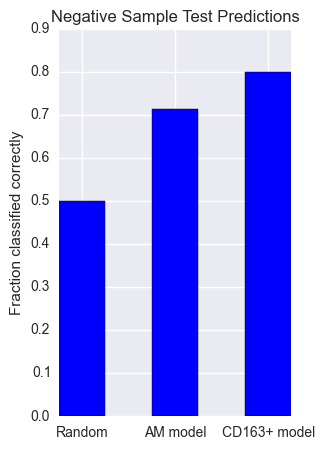

In [60]:
index = np.arange(3)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [0.5, testAM_100[1][0], test163_100[1][0]], width=width, color='b')
plt.xticks(index + width / 2, ('Random', 'AM model', 'CD163+ model'))
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Test Predictions")

In [12]:
def calc_metrics(X, y, n_pcs, n_top_genes):
    
    n_samples = len(X)
    pred = []
    vip_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    for sample in range(n_samples):
        samples = range(n_samples)
        samples.remove(sample)
        X_t = X[(samples)]
        y_t = y[(samples)]
        #print X_t.shape    
        
        ### Get VIPs for model built without the LOO sample
        plsv = PLSRegression(5, scale=False)
        plsv.fit(X_t, y_t)
        vips = vipp(X_t, y_t, plsv.x_scores_, plsv.x_weights_)
        vips = [float(v) for v in vips]
        vip_inds = np.argsort(vips)[::-1][:n_top_genes]
        vip_inds_all.append(vip_inds)
        
        ### Xn takes the original X to get the loo sample
        Xn = X.T[vip_inds].T
        loo_sample = Xn[sample]
        loo_sample = np.array(loo_sample).reshape((1, -1))
        
        ### Filter the samples 
        X_tn = X_t.T[vip_inds].T
        #print X_tn.shape
        pls = PLSRegression(n_pcs, scale=False)
        pls.fit(X_tn, y_t)

        pred.append(float(pls.predict(loo_sample)))

    # Calculate metrics
    ### Q squared
    num = sum([float((pred[i] - y[i]))**2 for i in range(len(pred))])
    den = sum([(y[i] - np.mean(y))**2 for i in range(len(pred))])
    Q2 = float(1 - num/den)

    ### Prediction error
    errs = [abs(float((pred[i] - y[i]))) for i in range(len(pred))]
 
    ### Percent correct for neg and pos Pneumonia
    neg_err = [errs[i] for i in range(len(errs)) if y[i]==0]  
    neg_corr = [e < 0.5 for e in neg_err]   
    neg_corr = float(sum(neg_corr)) / len(neg_err)

    
    pos_err = [errs[i] for i in range(len(errs)) if y[i]==1]
    pos_corr = [e < 0.5 for e in pos_err]
    pos_corr = float(sum(pos_corr)) / len(pos_err)
    

    #print "num: {0: .3f}, den: {1: .3f}, 
    #print "Q^2: {0: .3f}".format(Q2)
    
    return neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds_all
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

In [13]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [75]:
def calc_Q2_kfold(X, y, k=5, n_rand=10, n_pcs=5, method='PLSR'):
    n_samples = len(X)
    pred = []
    Q2s = []
    for ki in range(n_rand):
        sample_ind = range(n_samples)
        withheld_samples = random.sample(sample_ind, k)
        lo_samples = X[withheld_samples]
        for s in withheld_samples:
            sample_ind.remove(s)
        X_t = X[(sample_ind)]
        y_t = y[(sample_ind)]
        if method=='PLSR':
            model = PLSRegression(n_pcs, scale=False)
        elif method=='RF':
            model = RandomForestClassifier()
        elif method=='SVM':
            model = SVC()
        else:
            print "Method not found"
        model.fit(X_t, y_t)

        for s in withheld_samples:
            pred.append(float(model.predict(X[s])))
        #Eprint "samples", withheld_samples
        #Eprint "pred", pred
        num = sum([(pred[i] - y[s])**2 for i, s in enumerate(withheld_samples)])
        den = sum([(y[s] - np.mean(y[withheld_samples]))**2 for s in withheld_samples])
        Q2 = float(1- num/den)
        Q2s.append(Q2)
    print "Q^2: mean={0: .2f}, std={1: .2f}".format(np.mean(Q2s),np.std(Q2s))
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]